In [2]:
#Setting up the environment and importing libraries
from tensorflow.keras.models import Sequential
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow_hub as hub
import tensorflow_text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras import Model

In [2]:
#Importing necessary libraries and loading the dataset
import pandas as pd

df = pd.read_csv(r"D:\DataSets\train_v2_drcat_02.csv")
df.sample(5)


,text,label,prompt_name,source,RDizzl3_seven
29797,"As an 8th-grade student, I believe that indivi...",1,Distance learning,mistral7binstruct_v1,False
18612,"Dear Senator,\n\nI believe that is is time to ...",0,Does the electoral college work?,persuade_corpus,True
17146,I do not agree with the idea of completey driv...,0,Driverless cars,persuade_corpus,True
39077,Title: The Benefits of Intergenerational Inter...,1,Community service,llama2_chat,False
2215,People all over the world are saying goodbye t...,0,Car-free cities,persuade_corpus,True


In [3]:
# def remove_stopwords(text):
#     stop_words = set(stopwords.words('english'))
#     word_tokens = word_tokenize(text)
#     filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
#     return ' '.join(filtered_text)

# df['text'] = df['text'].apply(remove_stopwords)

# df.sample(5)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.15, random_state=42)

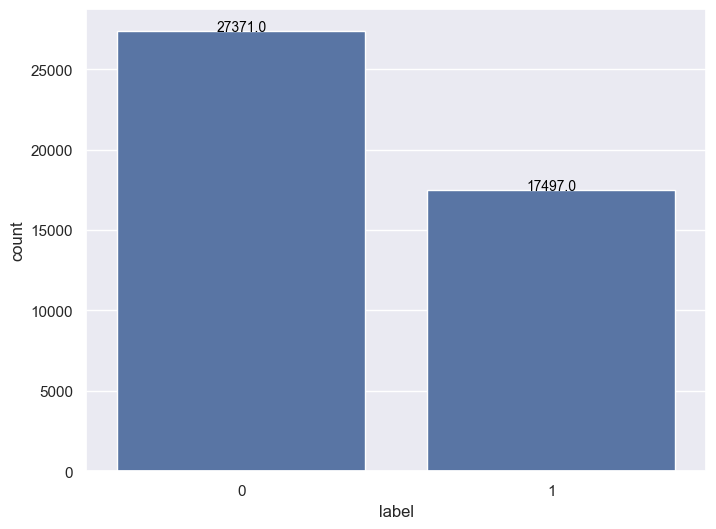

In [5]:
#Frequency of Labels
sns.set()
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Create a count plot
ax = sns.countplot(x="label", data=df)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black')

plt.show()

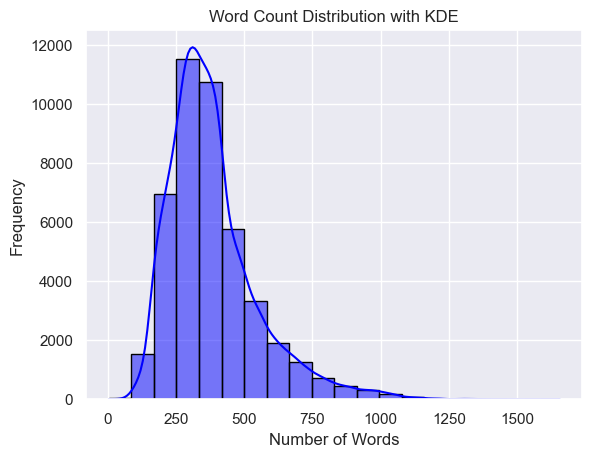

In [6]:
word_counts = df["text"].apply(lambda x: len(x.split()))

# Plot histogram with KDE
sns.histplot(word_counts, bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Word Count Distribution with KDE')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [2]:
bert_preprocess =hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4",trainable =True)

In [8]:
#text_input = Input(shape=(), dtype=tf.string,name='Text')
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
Preprocessor = bert_preprocess(text_input)
output = bert_encoder(Preprocessor)

In [9]:
# Neural network layers
x = Dense(256 , activation='relu',name="Dense_256" )(output["pooled_output"])
x = Dropout(0.5, name="dropout_1")(x)
x = Dense(64 , activation='relu',name="Dense_64" )(x)
x = Dropout(0.5, name="dropout_3")(x)
outputs = Dense(1, activation='sigmoid', name="output")(x)

# Use inputs and outputs to construct a final model
model = Model(inputs=[text_input], outputs = outputs)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=5e-5),
              loss="binary_crossentropy",
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

In [12]:
model.save("Aimodel.h5")

In [ ]:
def ml(x):
    loaded_model = load_model("Aimodel.h5", custom_objects={'KerasLayer': hub.KerasLayer})
    prediction = loaded_model.predict([x])
    prediction = (prediction  > 0.5).astype(int)
    if prediction ==[0]:
        return "Human"
    else:
        return "AI"



211/211 [==============================] - 757s 4s/step


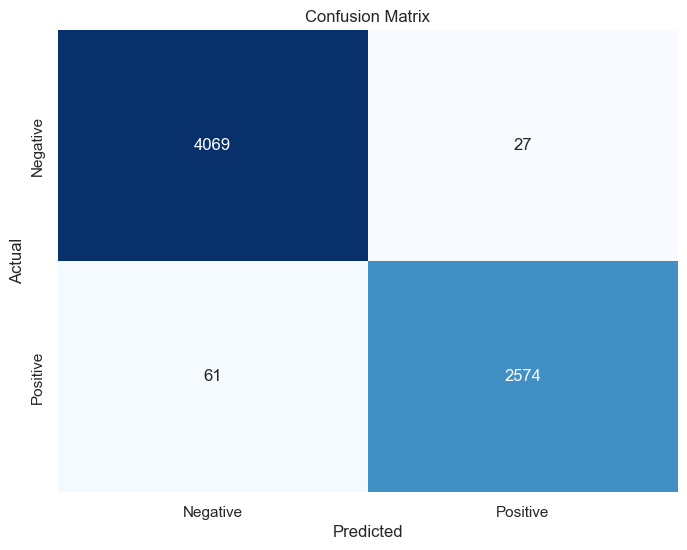

In [15]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

conf_mat = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9869261625315704
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4096
           1       0.99      0.98      0.98      2635

    accuracy                           0.99      6731
   macro avg       0.99      0.99      0.99      6731
weighted avg       0.99      0.99      0.99      6731



In [17]:
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, y_pred_binary)
print("ROC AUC Score:", roc_auc)

F1 Score: 0.9831932773109243
ROC AUC Score: 0.9851291490008302


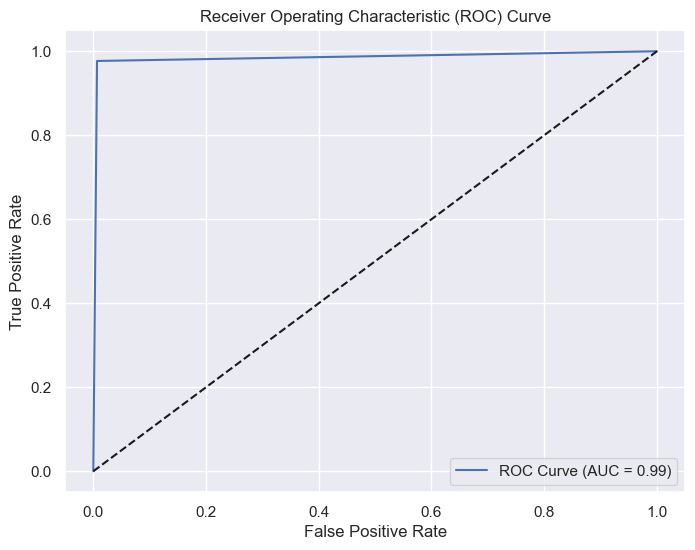

In [18]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_binary)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import tensorflow_text

# Load the model with custom objects
loaded_model = load_model("Aimodel.h5", custom_objects={'KerasLayer': hub.KerasLayer})

In [3]:
loaded_model.predict(["ensure that you're using a compatible version of TensorFlow with the SavedModel you're trying to load. Some operations might have been deprecated or removed in newer versions of TensorFlow."])

1/1 [==============================] - 2s 2s/step


array([[0.72049814]], dtype=float32)

In [16]:
prob = loaded_model.predict(["hi how are you"])

1/1 [==============================] - 0s 271ms/step
